In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving consumption_user.csv to consumption_user.csv
Saving subject_user.csv to subject_user.csv


In [3]:
subject = pd.read_csv("subject_user.csv")
consumption = pd.read_csv("consumption_user.csv")

print("Subject shape:", subject.shape)
print("Consumption shape:", consumption.shape)


Subject shape: (4341, 23)
Consumption shape: (137912, 76)


/tmp/ipython-input-972235144.py:2: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  consumption = pd.read_csv("consumption_user.csv")


In [4]:
subject.info()
consumption.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADM0_NAME         4341 non-null   object 
 1   ADM1_NAME         4341 non-null   object 
 2   ADM2_NAME         4341 non-null   object 
 3   WEIGHTING_FACTOR  4341 non-null   float64
 4   AREA_TYPE         4341 non-null   int64  
 5   HOUSEHOLD         4341 non-null   int64  
 6   SUBJECT           4341 non-null   int64  
 7   ROUND             4341 non-null   int64  
 8   SEX               4341 non-null   int64  
 9   AGE_YEAR          4341 non-null   float64
 10  ANT_DAY           0 non-null      float64
 11  ANT_MONTH         4341 non-null   int64  
 12  ANT_YEAR          4341 non-null   int64  
 13  WEIGHT            4194 non-null   float64
 14  HEIGHT            4178 non-null   float64
 15  METHOD_WEIGHT     4194 non-null   float64
 16  METHOD_HEIGHT     4178 non-null   float64


In [5]:
consumption = consumption.dropna(
    subset=["SUBJECT", "SURVEY_DAY", "FOODEX2_INGR_DESCR"]
)

print("După curățare:", consumption.shape)


După curățare: (137912, 76)


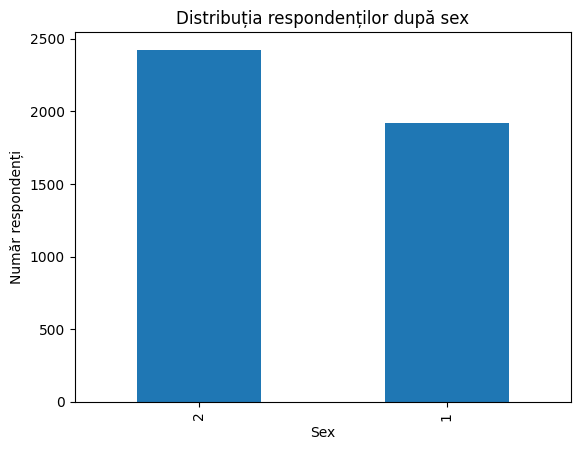

In [6]:
subject["SEX"].value_counts().plot(
    kind="bar",
    title="Distribuția respondenților după sex"
)
plt.xlabel("Sex")
plt.ylabel("Număr respondenți")
plt.show()


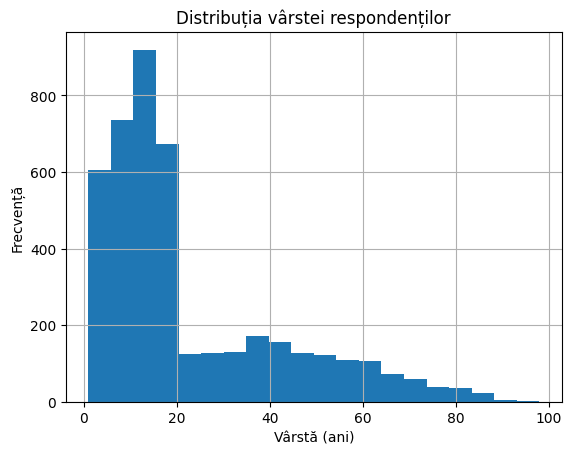

In [7]:
subject["AGE_YEAR"].hist(bins=20)
plt.title("Distribuția vârstei respondenților")
plt.xlabel("Vârstă (ani)")
plt.ylabel("Frecvență")
plt.show()


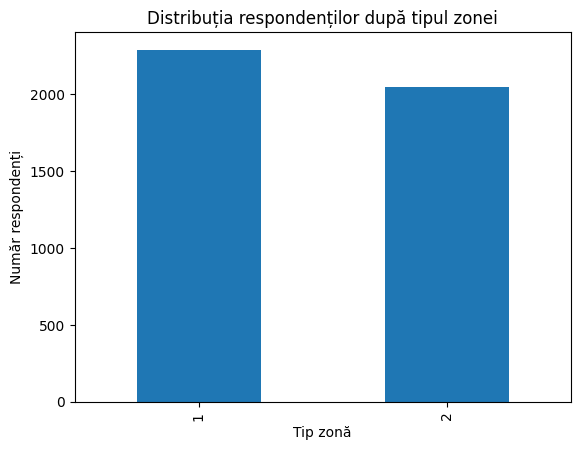

In [8]:
subject["AREA_TYPE"].value_counts().plot(
    kind="bar",
    title="Distribuția respondenților după tipul zonei"
)
plt.xlabel("Tip zonă")
plt.ylabel("Număr respondenți")
plt.show()


In [9]:
transactions = (
    consumption
    .groupby(["SUBJECT", "SURVEY_DAY"])["FOODEX2_INGR_DESCR"]
    .apply(lambda x: list(set(x)))
)

print("Număr tranzacții:", transactions.shape[0])


Număr tranzacții: 4642


In [10]:
transaction_lengths = transactions.apply(len)

transaction_lengths.describe()


,FOODEX2_INGR_DESCR
count,4642.000000
mean,22.361698
std,8.869250
min,1.000000
25%,16.000000
50%,21.000000
75%,27.000000
max,64.000000


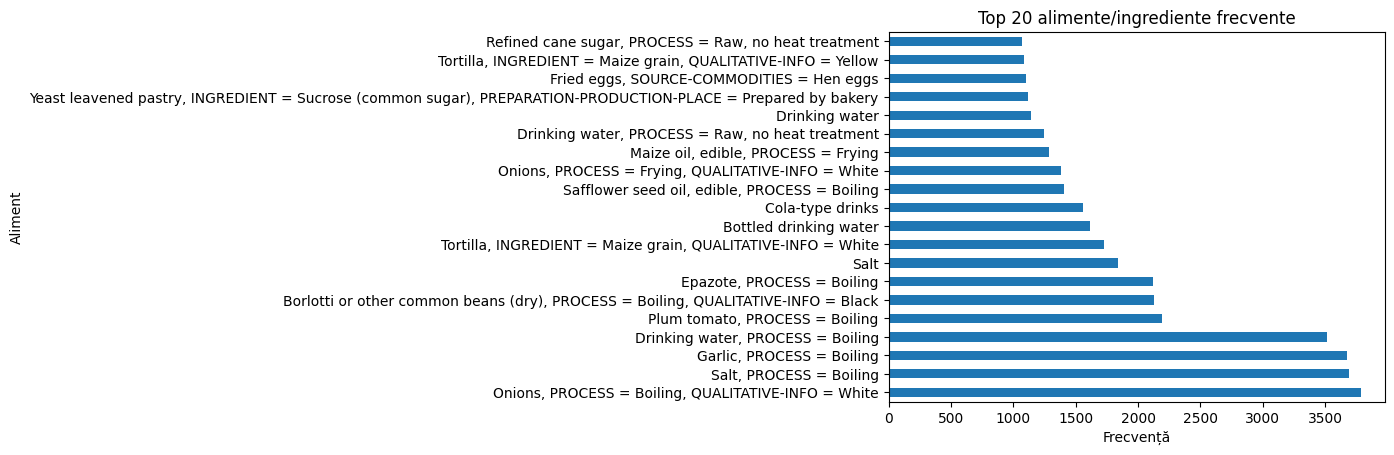

In [11]:
all_items = transactions.explode()

top_items = all_items.value_counts().head(20)

top_items.plot(kind="barh", title="Top 20 alimente/ingrediente frecvente")
plt.xlabel("Frecvență")
plt.ylabel("Aliment")
plt.show()


In [12]:
!pip install pyfpgrowth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5490 sha256=7ce8f87c2cdb8d44cf4cf7a7d41ab429ec1df78e118681b43561f59922a6047f
  Stored in directory: /root/.cache/pip/wheels/dc/18/5b/4a113996892937d01f5bfb727710d0dc569cfce1326014f8d0
Successfully built pyfpgrowth


In [13]:
transactions_list = transactions.tolist()


In [14]:
n_transactions = len(transactions_list)

min_support = 0.05
min_support_count = int(min_support * n_transactions)

min_confidence = 0.6

print("Nr tranzactii:", n_transactions)
print("Support minim (count):", min_support_count)
print("Confidence minim:", min_confidence)


Nr tranzactii: 4642
Support minim (count): 232
Confidence minim: 0.6


In [15]:
import pyfpgrowth

patterns = pyfpgrowth.find_frequent_patterns(
    transactions_list,
    min_support_count
)

print("Număr itemset-uri frecvente:", len(patterns))


Număr itemset-uri frecvente: 12009


In [16]:
rules = pyfpgrowth.generate_association_rules(
    patterns,
    min_confidence
)

print("Număr reguli generate:", len(rules))


Număr reguli generate: 11492


In [17]:
import pandas as pd

support_dict = {frozenset(k): v for k, v in patterns.items()}

rows = []

for antecedent, (consequent, confidence) in rules.items():
    antecedent = set(antecedent)
    consequent = set(consequent)
    union = antecedent | consequent

    support_union = support_dict.get(frozenset(union), 0)
    support_consequent = support_dict.get(frozenset(consequent), 0)

    if support_union == 0 or support_consequent == 0:
        continue

    support = support_union / n_transactions
    lift = confidence / (support_consequent / n_transactions)

    rows.append({
        "Antecedent": ", ".join(antecedent),
        "Consequent": ", ".join(consequent),
        "Support": support,
        "Confidence": confidence,
        "Lift": lift
    })

rules_df = pd.DataFrame(rows)
rules_df = rules_df.sort_values(
    by=["Lift", "Confidence", "Support"],
    ascending=False
)

rules_df.head(10)


,Antecedent,Consequent,Support,Confidence,Lift
29,"Rice grain, polished, PROCESS = Raw, no heat t...","Evaporated milk (liquid, unsweetened), PROCESS...",0.054287,0.996047,17.990864
27,"Evaporated milk (liquid, unsweetened), PROCESS...","Rice grain, polished, PROCESS = Raw, no heat t...",0.054287,0.980545,17.990864
28,"Evaporated milk (liquid, unsweetened), PROCESS...","Rice grain, polished, PROCESS = Raw, no heat t...",0.054287,0.996047,17.783278
477,"Plum tomato, PROCESS = Raw, no heat treatment,...","Onions, PROCESS = Boiling, QUALITATIVE-INFO = ...",0.049978,0.983051,7.977836
468,"Plum tomato, PROCESS = Raw, no heat treatment,...","Salt, PROCESS = Boiling, Mayonnaise sauce, PRO...",0.049978,0.966667,7.683676
423,"Garlic, PROCESS = Boiling, Avocados, PROCESS =...","Salt, PROCESS = Boiling, Plum tomato, PROCESS ...",0.049978,0.962656,7.612687
458,"Mayonnaise sauce, PROCESS = Raw, no heat treat...","Plum tomato, PROCESS = Raw, no heat treatment,...",0.049978,0.983051,7.468612
457,"Mayonnaise sauce, PROCESS = Raw, no heat treat...","Salt, PROCESS = Boiling, Plum tomato, PROCESS ...",0.049978,0.966667,7.237527
1630,"Meat soup, clear, PROCESS = Boiling, Pasta, pl...","Plum tomato, PROCESS = Boiling, Garlic, PROCES...",0.057734,0.971014,4.646855
1645,"Meat soup, clear, PROCESS = Boiling, Onions, P...","Garlic, PROCESS = Boiling, Salt, PROCESS = Boi...",0.057734,0.971014,4.632528


from matplotlib import pyplot as plt
_df_0['Support'].plot(kind='hist', bins=20, title='Support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Confidence'].plot(kind='hist', bins=20, title='Confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Lift'].plot(kind='hist', bins=20, title='Lift')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Support', y='Confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Confidence', y='Lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Support'].plot(kind='line', figsize=(8, 4), title='Support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Confidence'].plot(kind='line', figsize=(8, 4), title='Confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Lift'].plot(kind='line', figsize=(8, 4), title='Lift')
plt.gca().spines[['top', 'right']].set_visible(False)